In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
transform = transforms.Compose([ transforms.Resize((28,28)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.5],
                                                       std = [0.5] ) ])


training_dataset = datasets.MNIST(root = "./data", train = True, download= True, transform = transform)
validation_dataset = datasets.MNIST(root = "./data", train = False, download = True,transform = transform )

In [52]:
training_loader = DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

In [53]:
len(training_dataset),len(training_loader)

(60000, 600)

In [54]:
def img_convert(tensor):

    image = tensor.clone().detach().numpy()
    image = image.transpose((1,2,0))
    image = image * np.array(0.5) + np.array([0.5])
    image = image.clip(0,1)

    return image

In [55]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

In [56]:
images.max(),images.min()

(tensor(1.), tensor(-1.))

In [57]:
test = img_convert(images[0])
test.max(),test.min(),test.shape

(1.0, 0.0, (28, 28, 1))

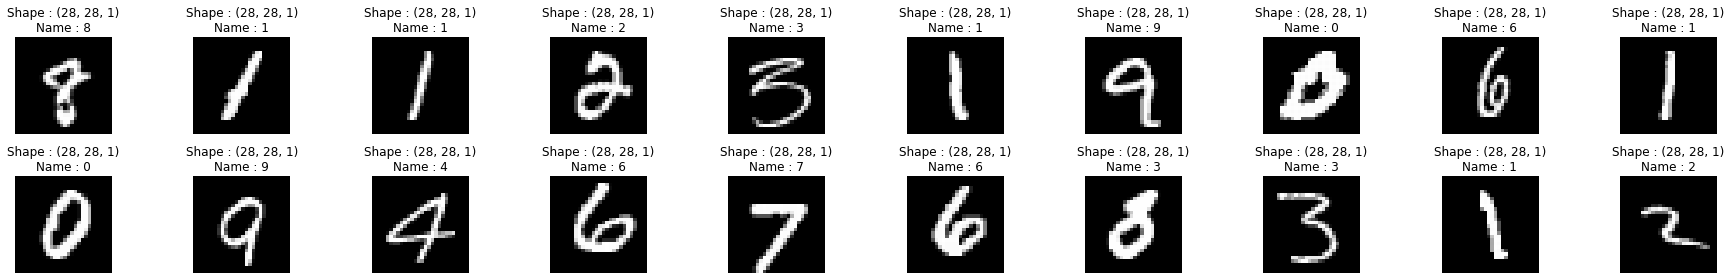

In [58]:
fig = plt.figure(figsize = (25,4))

for idx in range(20):

    ax = fig.add_subplot(2,10, idx+1)
    convert_img = img_convert(images[idx])

    plt.imshow(convert_img.reshape((28,28)), cmap = "gray")
    plt.title(f"Shape : {convert_img.shape}\nName : {labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [78]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        #in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
        self.conv1 = nn.Conv2d(1 , 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5,1)
        self.fc1 =  nn.Linear(4*4*50, 500)
        self.dropout1 = nn.Dropout(p = 0.5)
        self.fc2 =  nn.Linear(500, 10)

    def forward(self,X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X , 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X , 2, 2)
        X = X.view(-1,4*4*50)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = self.fc2(X)

        #return X
        return F.log_softmax(X, 1)


In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [80]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [81]:
for name , param in model.named_parameters():
    print(name, "\t", param.shape)
    print("".center(100,"-"))

conv1.weight 	 torch.Size([20, 1, 5, 5])
----------------------------------------------------------------------------------------------------
conv1.bias 	 torch.Size([20])
----------------------------------------------------------------------------------------------------
conv2.weight 	 torch.Size([50, 20, 5, 5])
----------------------------------------------------------------------------------------------------
conv2.bias 	 torch.Size([50])
----------------------------------------------------------------------------------------------------
fc1.weight 	 torch.Size([500, 800])
----------------------------------------------------------------------------------------------------
fc1.bias 	 torch.Size([500])
----------------------------------------------------------------------------------------------------
fc2.weight 	 torch.Size([10, 500])
----------------------------------------------------------------------------------------------------
fc2.bias 	 torch.Size([10])
----------------------

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [83]:
len(training_dataset),len(training_loader), len(training_loader) / 100

(60000, 600, 6.0)

In [84]:
len(validation_dataset),len(validation_loader), len(validation_loader) / 100

(10000, 100, 1.0)

In [85]:
import time

epochs = 12
start_time = time.time()

train_losses = []
test_losses = []

train_correct = []
test_correct = []


for epoch in range(epochs):

    trn_corr = 0.0
    tst_corr = 0.0
    
    trn_loss = 0.0
    tst_loss = 0.0

    for b,(X_train, y_train) in enumerate(training_loader):

        b+=1
        inputs = X_train.to(device)
        y_train = y_train.to(device)
 
        outputs = model.forward(inputs)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.max(outputs , 1)[1]
        trn_corr += (y_pred.data == y_train).sum()
        trn_loss +=loss.item()

        if b % 100 == 0 :
            print(f"Epoch : {epoch+1:4}, Batch : {b:3} [{b*100}/60000] , Loss : {loss.item():4.4f}, Accurcay : {trn_corr * 100 / (b*100):.4f}%")

    else:
        with torch.no_grad():
            for X_test,y_test in  validation_loader:

                val_inputs = X_test.to(device)
                y_test = y_test.to(device)

                val_outputs = model.forward(val_inputs)

                val_loss = criterion(val_outputs,y_test)
                val_pred = torch.max(val_outputs,1)[1]

                tst_corr += (val_pred == y_test).sum()
                tst_loss += val_loss.item()



        train_loss = trn_loss / len(training_loader)
        train_corr = trn_corr.float() / len(training_loader)

        test_loss = tst_loss / len(validation_loader)
        test_corr = tst_corr.float() / len(validation_loader)


        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_correct.append(train_corr)
        test_correct.append(test_corr)

        print()
        print("".center(100,"-"))
        print()
        
        print(f"For Epoch : {epoch+1}")
        print("Training Loss : {:.4f}, Training Accuracy {:.4f}%".format(train_loss, train_corr.item()))
        print("Validation Loss : {:.4f}, Validation Accuracy {:.4f}%".format(test_loss, test_corr.item()))
        
        print()
        print("".center(100,"-"))
        print()


total_time = time.time() - start_time
print(f"\nDuration : {total_time} seconds ...")

Epoch :    1, Batch : 100 [10000/60000] , Loss : 0.9762, Accurcay : 60.6100%
Epoch :    1, Batch : 200 [20000/60000] , Loss : 0.3085, Accurcay : 72.6850%
Epoch :    1, Batch : 300 [30000/60000] , Loss : 0.2734, Accurcay : 78.4400%
Epoch :    1, Batch : 400 [40000/60000] , Loss : 0.2423, Accurcay : 81.7150%
Epoch :    1, Batch : 500 [50000/60000] , Loss : 0.1662, Accurcay : 84.0620%
Epoch :    1, Batch : 600 [60000/60000] , Loss : 0.2455, Accurcay : 85.8000%

----------------------------------------------------------------------------------------------------

For Epoch : 1
Training Loss : 0.5618, Training Accuracy 85.8000%
Validation Loss : 0.1679, Validation Accuracy 94.8300%

----------------------------------------------------------------------------------------------------

Epoch :    2, Batch : 100 [10000/60000] , Loss : 0.2013, Accurcay : 94.5200%
Epoch :    2, Batch : 200 [20000/60000] , Loss : 0.1620, Accurcay : 94.8700%
Epoch :    2, Batch : 300 [30000/60000] , Loss : 0.2766, A

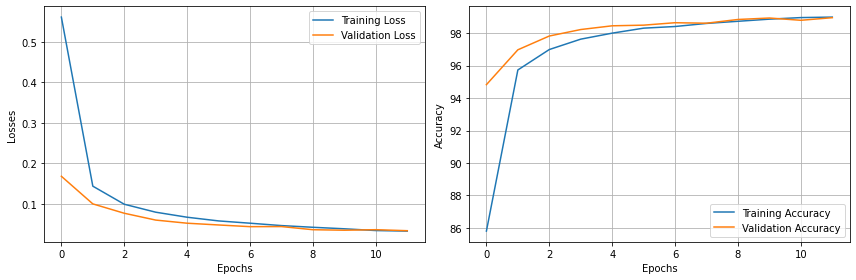

In [86]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc = "best")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(train_correct, label = "Training Accuracy")
plt.plot(test_correct,  label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.grid(True)

plt.tight_layout()
plt.show()

In [87]:
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
url

'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

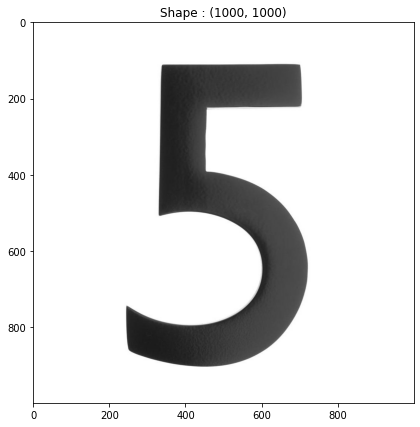

In [88]:
import requests
from PIL import Image
import cv2
import PIL

response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.figure(figsize = (7,7))
plt.imshow(img)
plt.title(f"Shape : {img.size}")
plt.show()

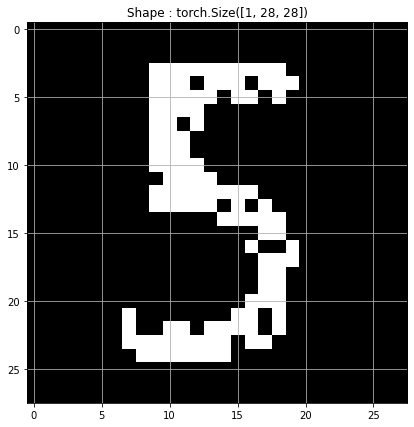

In [106]:
response = requests.get(url, stream = True)
img = Image.open(response.raw)
img = PIL.ImageOps.invert(img)
img = img.convert("1")
img = transform(img)

plt.figure(figsize = (7,7))
plt.imshow(img_convert(img).reshape(28,28), cmap = "gray")
plt.title(f"Shape : {img.shape}")
plt.grid(True)
plt.show()

In [127]:
def predictions(image):
    
    with torch.no_grad():

        image = image.to(device)
        inputs = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
        outputs = model(inputs)
        pred = torch.max(outputs, 1)[1]

    #print("Predictions :", pred.item())
    return pred.item()

In [128]:
print("Predictions : ", predictions(img) )

Predictions :  5


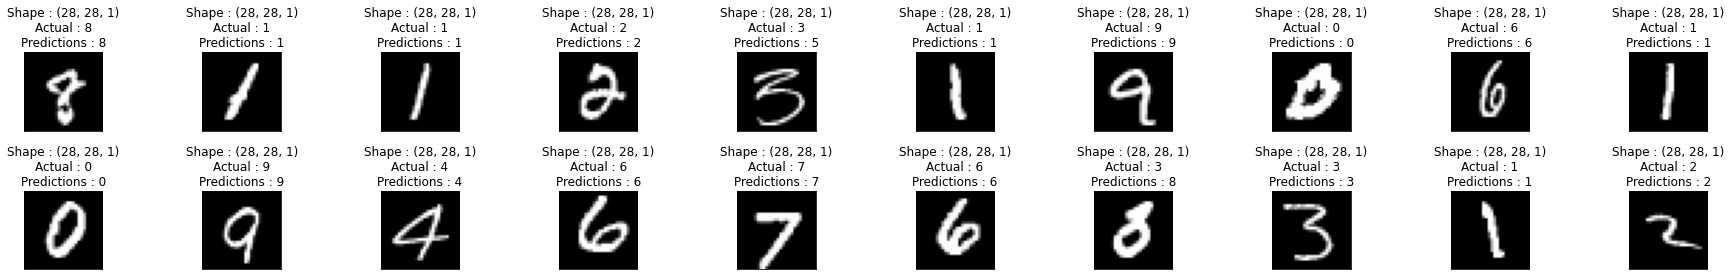

In [129]:
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):

    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])

    convert = img_convert(images[idx])
    plt.imshow(convert.reshape((28,28)), cmap = "gray")

    pred = predictions(images[idx])
    ax.set_title(f"Shape : {convert.shape}\nActual : {labels[idx]}\nPredictions : {pred}")
 

plt.tight_layout()
plt.show()

---

In [170]:
all_data_loader = DataLoader(dataset = validation_dataset,batch_size = len(validation_dataset), shuffle = False)

In [171]:
for validation_images, validation_labels in all_data_loader:
    break

In [172]:
validation_images.shape, validation_labels.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [173]:
with torch.no_grad():

    inputs = validation_images.to(device)
    outputs = model.forward(inputs)
    pred = torch.max(outputs,1)[1]

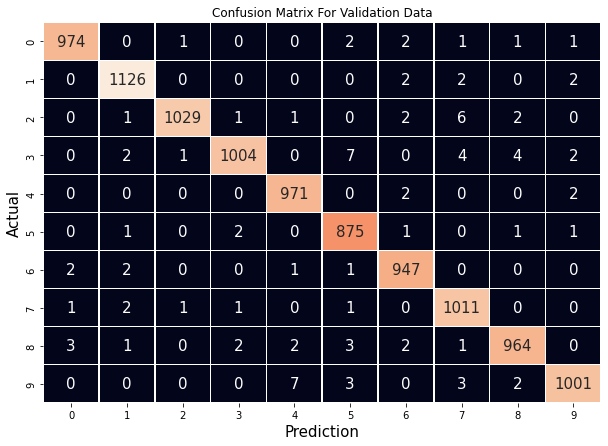

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(pred.cpu(),validation_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, linewidth = 0.5, fmt = "d", linecolor="white", annot_kws={"size":15}, cbar = False)
plt.title("Confusion Matrix For Validation Data")
plt.ylabel("Actual", fontsize = 15)
plt.xlabel("Prediction", fontsize = 15)
plt.show()

----

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [164]:
def img_convert(tensor):

    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array([0.5,0.5,0.5]) + np.array([0.5,0.5,0.5])
    image = image.clip(0,1)
    return image

In [166]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(p = 0.5,),
                                      transforms.RandomRotation(degrees = 10,),  # -10,+10 rastgele
                                      transforms.RandomAffine(degrees = 0 , shear = 10, scale = (0.8, 1.2)), # Ya zoom ya unzoom yada yamuk dörtgen gibi 10 dereceli
                                      transforms.ColorJitter(brightness=0.2, contrast = 0.2, saturation = 0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
                                     ])

transform_test = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.5,0.5,0.5], 
                                                          std = [0.5,0.5,0.5])])

training_dataset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform_train)
validation_dataset = datasets.CIFAR10(root = "./data" , train = False, download = True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


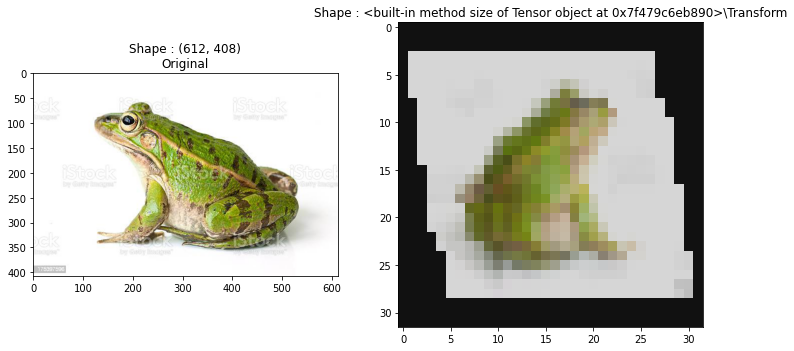

In [168]:
url = "https://media.istockphoto.com/photos/frog-picture-id175397596?s=612x612"
response = requests.get(url,stream = True)
img = Image.open(response.raw)
img_trans = transform_train(img)

plt.figure(figsize = (12,10))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Shape : {img.size}\nOriginal")

plt.subplot(1,2,2)
plt.imshow(img_convert(img_trans))
plt.title(f"Shape : {img_trans.size}\Transform")
plt.show()

In [169]:
len(training_dataset),len(validation_dataset)

(50000, 10000)

In [170]:
class_names = training_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [171]:
training_loader = DataLoader(dataset=training_dataset, batch_size = 100, shuffle = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

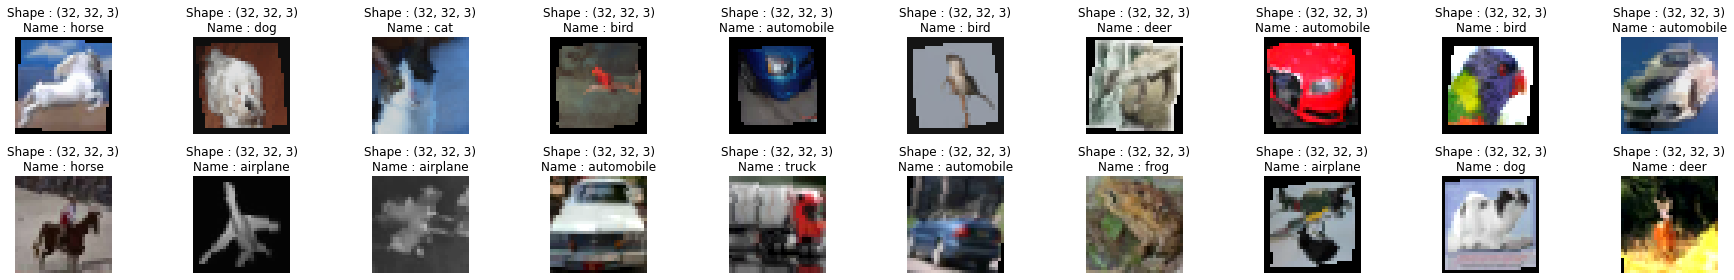

In [172]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize = (25,4))

for idx in range(20):

    ax = fig.add_subplot(2,10,idx+1)
    convert = img_convert(images[idx])
    ax.imshow(convert)
    plt.title(f"Shape : {convert.shape}\nName : {class_names[labels[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [174]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,1, padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,1, padding = 1)
        self.conv3 = nn.Conv2d(32,64,3,1, padding = 1)

        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(p = 0.5)
        self.fc2 =nn.Linear(500,10)

    def forward(self,X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2,2)

        X = X.view(-1,4*4*64)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = self.fc2(X)

        return X

In [175]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [176]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [177]:
import time

epochs = 15
start_time = time.time()

train_losses = []
test_losses = []

train_correct = []
test_correct = []


for epoch in range(epochs):

    trn_corr = 0.0
    tst_corr = 0.0
    
    trn_loss = 0.0
    tst_loss = 0.0

    for b,(X_train, y_train) in enumerate(training_loader):

        b+=1
        inputs = X_train.to(device)
        y_train = y_train.to(device)
 
        outputs = model.forward(inputs)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.max(outputs , 1)[1]
        trn_corr += (y_pred.data == y_train).sum()
        trn_loss +=loss.item()

        if b % 100 == 0 :
            print(f"Epoch : {epoch+1:4}, Batch : {b:3} [{b*100}/50000] , Loss : {loss.item():4.4f}, Accurcay : {trn_corr * 100 / (b*100):.4f}%")

    else:
        with torch.no_grad():
            for X_test,y_test in  validation_loader:

                val_inputs = X_test.to(device)
                y_test = y_test.to(device)

                val_outputs = model.forward(val_inputs)

                val_loss = criterion(val_outputs,y_test)
                val_pred = torch.max(val_outputs,1)[1]

                tst_corr += (val_pred == y_test).sum()
                tst_loss += val_loss.item()



        train_loss = trn_loss / len(training_loader)
        train_corr = trn_corr.float() / len(training_loader)

        test_loss = tst_loss / len(validation_loader)
        test_corr = tst_corr.float() / len(validation_loader)


        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_correct.append(train_corr)
        test_correct.append(test_corr)

        print()
        print("".center(100,"-"))
        print()
        
        print(f"For Epoch : {epoch+1}")
        print("Training Loss : {:.4f}, Training Accuracy {:.4f}%".format(train_loss, train_corr.item()))
        print("Validation Loss : {:.4f}, Validation Accuracy {:.4f}%".format(test_loss, test_corr.item()))
        
        print()
        print("".center(100,"-"))
        print()


total_time = time.time() - start_time
print(f"\nDuration : {total_time} seconds ...")

Epoch :    1, Batch : 100 [10000/50000] , Loss : 2.1341, Accurcay : 17.2400%
Epoch :    1, Batch : 200 [20000/50000] , Loss : 2.0369, Accurcay : 21.4800%
Epoch :    1, Batch : 300 [30000/50000] , Loss : 1.9649, Accurcay : 24.1733%
Epoch :    1, Batch : 400 [40000/50000] , Loss : 1.7646, Accurcay : 26.1100%
Epoch :    1, Batch : 500 [50000/50000] , Loss : 1.8158, Accurcay : 27.4760%

----------------------------------------------------------------------------------------------------

For Epoch : 1
Training Loss : 1.9948, Training Accuracy 27.4760%
Validation Loss : 1.7497, Validation Accuracy 37.5000%

----------------------------------------------------------------------------------------------------

Epoch :    2, Batch : 100 [10000/50000] , Loss : 1.9049, Accurcay : 35.5500%
Epoch :    2, Batch : 200 [20000/50000] , Loss : 1.6314, Accurcay : 35.9150%
Epoch :    2, Batch : 300 [30000/50000] , Loss : 1.7729, Accurcay : 36.1033%
Epoch :    2, Batch : 400 [40000/50000] , Loss : 1.7418, A

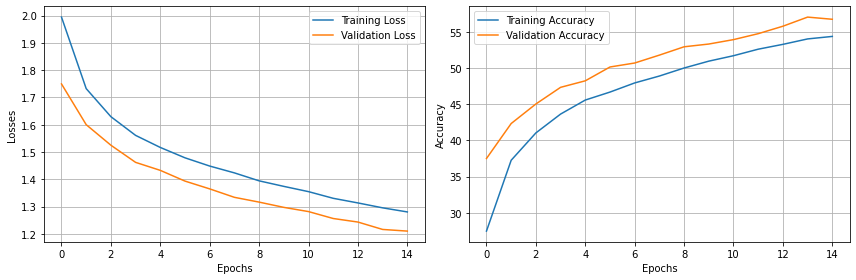

In [178]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc = "best")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(train_correct, label = "Training Accuracy")
plt.plot(test_correct,  label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.grid(True)

plt.tight_layout()
plt.show()

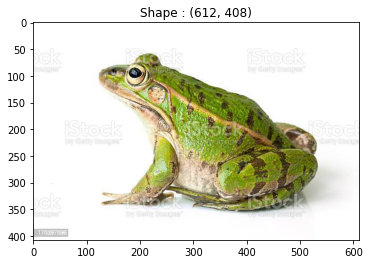

In [179]:
import requests
from PIL import Image
import PIL

url = "https://media.istockphoto.com/photos/frog-picture-id175397596?s=612x612"
response = requests.get(url,stream = True)
img = Image.open(response.raw)

plt.imshow(img)
plt.title(f"Shape : {img.size}")
plt.show()


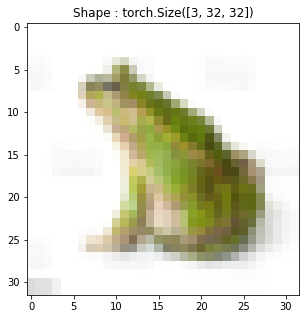

In [180]:
url = "https://media.istockphoto.com/photos/frog-picture-id175397596?s=612x612"
response = requests.get(url,stream = True)
img = Image.open(response.raw)
img = transform(img)

plt.figure(figsize = (12,5))
plt.imshow(img_convert(img))
plt.title(f"Shape : {img.shape}")
plt.show()

In [181]:
def predictions(image):
    
    with torch.no_grad():

        image = image.to(device)
        inputs = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
        outputs = model(inputs)
        pred = torch.max(outputs, 1)[1]

    #print("Predictions :", pred.item())
    return class_names[pred.item()]

In [182]:
print("Predictions : ", predictions(img))

Predictions :  frog


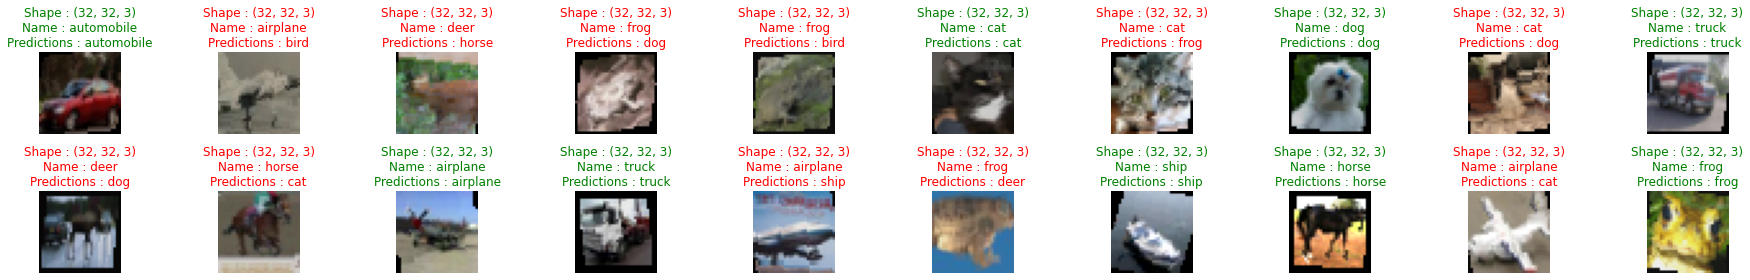

In [185]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize = (25,4))

for idx in range(20):

    ax = fig.add_subplot(2,10,idx+1)
    convert = img_convert(images[idx])
    ax.imshow(convert)

    pred = predictions(images[idx])
    #plt.title(f"Shape : {convert.shape}\nName : {class_names[labels[idx]]}\nPredictions : {pred}")
    plt.title("Shape : {}\nName : {}\nPredictions : {}".format(convert.shape, class_names[labels[idx]], pred),
              color = ("green" if pred == class_names[labels[idx]] else "red"))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [186]:
all_data_loader = DataLoader(dataset = validation_dataset,batch_size = len(validation_dataset), shuffle = False)

for validation_images, validation_labels in all_data_loader:
    break

with torch.no_grad():

    inputs = validation_images.to(device)
    outputs = model.forward(inputs)
    pred = torch.max(outputs,1)[1]

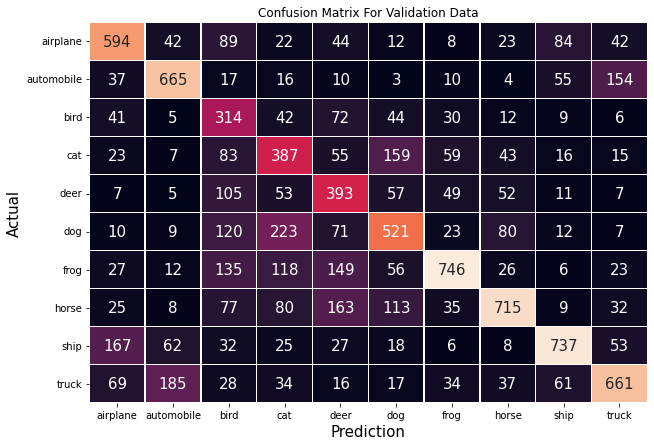

In [188]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(pred.cpu(),validation_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, linewidth = 0.5, fmt = "d", linecolor="white", annot_kws={"size":15}, cbar = False,xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix For Validation Data")
plt.ylabel("Actual", fontsize = 15)
plt.xlabel("Prediction", fontsize = 15)
plt.show()